In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
% env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
import sys; sys.path += ['..', '../src']

In [4]:
import os
from itertools import islice

from src.vocab import Vocab

DATA_PATH = '../data/generated'

# We set rather large min_len, because our BPEs are very short
min_len = 50
max_len = 250

classics_path = os.path.join(DATA_PATH, 'classics.ne.split.tok.bpe')
news_path = os.path.join(DATA_PATH, 'news.ru.tok.ne.bpe')

classics = open(classics_path, 'r', encoding='utf-8').read().splitlines()
news = open(news_path, 'r', encoding='utf-8').read().splitlines()
# TODO: replace with full file when dev is done
# with open(classics_path, encoding='utf-8') as classics_file, open(news_path, encoding='utf-8') as news_file:
#     classics = list(islice(classics_file, 10**4))
#     news = list(islice(news_file, 10**4))

classics = [s for s in classics if min_len < len(s.split()) < (max_len - 2)]
news = [s for s in news if min_len < len(s.split()) < (max_len - 2)]

# There are sentences which do not contain a single normal
# (i.e. fully alphabetic) word. Let's remove them.
classics = [s for s in classics if any([w.isalpha() for w in s.replace('@@ ', '').split()])]
news = [s for s in news if any([w.isalpha() for w in s.replace('@@ ', '').split()])]

vocab = Vocab.from_sequences(classics + news)
vocab.token2id['__DROP__'] = len(vocab)
vocab.tokens.append('__DROP__')

In [5]:
import random
import numpy as np

np.random.seed(42)

np.random.shuffle(classics)
np.random.shuffle(news)

In [6]:
classics, classics_val = classics[:-1000], classics[-1000:]
news, news_val = news[:-1000], news[-1000:]

In [7]:
%matplotlib inline

import os
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam

from src.models import Transformer
from src.dataloaders import WordRecoveryDataloader, OneSidedDataloader
from src.vocab import constants
from src.trainers import WordRecoveryTrainer

log_file_path = '../logs/word_recovery.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

transformer = Transformer(len(vocab), len(vocab), max_len)
transformer.load_state_dict(torch.load('../trained_models/word_recovery.pth'))

optimizer = Adam(transformer.get_trainable_parameters(), lr=1e-5)
criterion = reconstruction_criterion(len(vocab))

config = {
    'max_num_epochs': 5,
    'plot_every': 50,
    'validate_every': 200,
    'mixing_scheme': (0, 0, 100000),
    'log_file': log_file_path,
    'max_len': 20,
    'early_stopping_last_n_iters': 10000
}

trainer = WordRecoveryTrainer(transformer, optimizer, criterion, vocab, config)
training_data = WordRecoveryDataloader(classics, news, vocab, trainer.mixing_coef, batch_size=32, shuffle=True)
val_data = WordRecoveryDataloader(classics_val[:512], news_val[:512], vocab, batch_size=512)

# Making validation data deterministic
val_data = np.array(next(val_data)).transpose().tolist()
val_data = OneSidedDataloader(val_data, batch_size=32, unpack=True, pad=False)

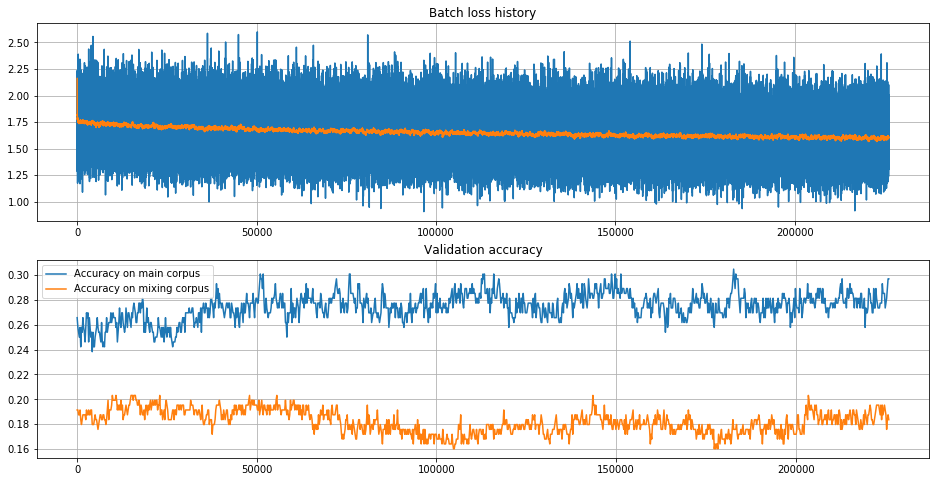

In [8]:
trainer.run_training(training_data, val_data)

In [26]:
torch.save(transformer.state_dict(), '../trained_models/word_recovery.pth')

Ok, let's now try to translate some news.
For this we should generate from a sentence (of $n$ words) $n$ sentences with `__DROP__` word in place of each word.
Named entities, I suppose, should be transferred as is. But this will be the next iteration.

In [17]:
vocab.token2id['_']

126

In [19]:
from tqdm import tqdm

from src.dataloaders.word_recovery_dataloader import drop_each_word, group_bpes_into_words
from src.utils.data_utils import token_ids_to_sents, pad_to_longest
from src.vocab import constants

results = []

transformer.eval()
all_beams = []
for sentence in tqdm(news_val[0:10]):
    sentence = sentence.replace('__NE_PER__', '_ _ NE _ PER _ _')
    sentence = sentence.replace('__NE_LOC__', '_ _ NE _ LOC _ _')
    sentence = sentence.replace('__NE_ORG__', '_ _ NE _ ORG _ _')
    sentence = sentence.replace('_;', '_ ;')
    seqs, _, words_idx = drop_each_word(sentence)
    seqs_idx = [[vocab.token2id[t] for t in s.split()] for s in seqs]
    seqs_idx = [[constants.BOS] + s + [constants.EOS] for s in seqs_idx]
    seqs_idx = pad_to_longest(seqs_idx, volatile=True)
    predictions, beams = transformer.translate_batch(seqs_idx, beam_size=1, max_len=20, return_beams=True)
    predictions = token_ids_to_sents(predictions, vocab)
    
    # Now we should construct initial sentence with some care,
    # because not each word was dropped, but only normal ones (fully alphabetical)
    words = group_bpes_into_words(sentence)
    for i, w in enumerate(predictions): words[words_idx[i]] = w
    sentence = ' '.join(words)

    results.append(sentence)
    all_beams.append(beams)

for i in range(10):
    print('Source: ', news_val[i].replace('@@ ', ''))
    print('Result: ', results[i].replace('@@ ', ''))
    print()

100%|██████████| 10/10 [00:01<00:00,  6.89it/s]

Source:  Подопечные __NE_PER__ вышли в четверг с первого места из группы Лиги __NE_LOC__ за два тура до финиша , седьмой год подряд пробившись в еврокубковую весну .
Result:  Когда _ _ NE _ PER _ _ вышли на кабинет из первого дня из города в _ _ NE _ PER _ _ за день дня и смерти , через в и попал в свою шляпу .

Source:  По ходу он прокачивает скиллы , необходимые для того , чтобы сражаться с современными тамплиерами , - в альтернативной истории этим занимаются специальные ассасины .
Result:  По причине не проживал силы , необходимые для того , чтобы познакомиться с их продуктами , - в этой с не образом некоторые продукты .

Source:  Помимо этого , не так давно в Сети появились утекшие изображения нового iPhone , на которых можно заметить вторую камеру на задней стороне смартфона .
Result:  Кроме них , и только как в ней и все слова о положения , в котором могла найти свою позицию по той стороне колокола .

Source:  А вчера на его счету оказались обе заброшенные &quot; __NE_ORG__; во в

In [11]:
def inference(sentence, return_scores=False, beam_size=1):
    seqs, _, words_idx = drop_each_word(sentence)
    seqs_idx = [[vocab.token2id[t] for t in s.split()] for s in seqs]
    seqs_idx = [[constants.BOS] + s + [constants.EOS] for s in seqs_idx]
    seqs_idx = pad_to_longest(seqs_idx, volatile=True)
    predictions, beams = transformer.translate_batch(seqs_idx, beam_size=beam_size, max_len=20, return_beams=True)
    words_predictions = token_ids_to_sents(predictions, vocab)
    
    # Now we should construct initial sentence with some care,
    # because not each word was dropped, but only normal ones (fully alphabetical)
    words = group_bpes_into_words(sentence)
    for i, w in enumerate(words_predictions): words[words_idx[i]] = w
    translation = ' '.join(words)
    
    score = lambda i: (beams[words_idx.index(i)].scores.max() / len(beams[words_idx.index(i)].all_scores))
    scores = [(normal_word_idx, word_idx, score(word_idx)) for normal_word_idx, word_idx in enumerate(words_idx)]

    if return_scores:
        return translation, predictions, scores
    else:
        return translation

In [12]:
from src.dataloaders.word_recovery_dataloader import get_words_idx

def sequential_inference(sentence):
    """
    Here we gonna make a more complex inference: we gonna
    sequentially choose and replace best words
    """
    translated_words_idx = set()
    words = group_bpes_into_words(sentence)
    num_normal_words = len(get_words_idx(sentence.replace('@@ ', '').split()))
    
    for _ in range(num_normal_words):
        #print(words)
        _, predictions, scores = inference(' '.join(words), return_scores=True)

        # Now we should choose which word to translate
        scores.sort(key=lambda x:x[1], reverse=True)
        normal_word_idx, word_idx, score = next(s for s in scores if not s[1] in translated_words_idx)
        #print('\n', vocab.detokenize(predictions[word_idx][:-1]), '\n')
        #print(word_idx, scores)
        words[word_idx] = vocab.detokenize(predictions[normal_word_idx][:-1])
        translated_words_idx.add(word_idx)
        
    return words

In [23]:
def replace_to(s):
    s = s.replace('__NE_PER__', '_ _ NE _ PER _ _')
    s = s.replace('__NE_LOC__', '_ _ NE _ LOC _ _')
    s = s.replace('__NE_ORG__', '_ _ NE _ ORG _ _')
    s = s.replace('_;', '_ ;')
    
    return s

def replace_from(s):
    s = s.replace('_ _ NE _ PER _ _', '__NE_PER__')
    s = s.replace('_ _ NE _ LOC _ _', '__NE_LOC__')
    s = s.replace('_ _ NE _ ORG _ _', '__NE_ORG__')
    s = s.replace('_ ;', '_;')
    
    return s

In [25]:
for sentence in tqdm(news_val[15:20]):
    sentence = replace_to(sentence)
    translation = ' '.join(sequential_inference(sentence))
    
    print('Source', replace_from(sentence.replace('@@ ', '')))
    print('Result:', replace_from(translation.replace('@@ ', '')))

 20%|██        | 1/5 [00:03<00:13,  3.34s/it]

Source В больницу , по словам заместителя главы администрации - начальника департамента информационной политики __NE_PER__ , Городецкий попал в больницу с простудой .
Result: В сущности , по смерти Великого Великого Вильгельма - свидетельствующие войны в армии __NE_PER__ , он вступил в связь с французами .


 40%|████      | 2/5 [00:07<00:11,  3.89s/it]

Source __NE_PER__ отметил : __NE_ORG__; __NE_LOC__ полвека накапливал радиоактивные отходы в виде отработанного топлива , выведенного из эксплуатации атомного флота , и теперь их очищают и кондиционируют .
Result: __NE_PER__ Смотрите : __NE_PER__; __NE_PER__ не попадает на поступки в пользу своего пола , одного из них в тех , которые все их занимают и занимают .


 60%|██████    | 3/5 [00:17<00:11,  5.86s/it]

Source Реализация всех этапов развития железнодорожной инфраструктуры рассчитана до 2018 года , а общий объем капвложений оценивается более чем в 6,7 млрд руб. Ожидаемый объем перевозок на данном направлении после завершения строительства моста и реконструкции участка к 2020 году может составить 5,2 млн т , к 2025 году - 7,7 млн т.
Result: Из производства работ из этой системы выяснила в 2018 год , что этот продукт рабочих стоит более чем на 6,7 млн руб. млрд для участия в этом уровне для заработной работы в тысячи фунтов и в 2020 года может пройти 5,2 млн рублей , а 2025 марта - 7,7 и т.


 80%|████████  | 4/5 [00:21<00:05,  5.45s/it]

Source В то же время , как считает __NE_PER__ , РСЧС должна постепенно отходить от принципа оперативного реагирования к принципу профилактики - предупреждению чрезвычайных ситуаций и управлению рисками .
Result: В то самое время , как говорил __NE_PER__ , она должна была отказываться от удовольствия и отношения к уровню народа - потребление этих условий и потребительных народов .


100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

Source Сообщается , что по плану , __NE_PER__ , __NE_PER__ и Корниенко должны были сами выбраться из капсулы , имитирую посадку на __NE_LOC__ , но им не удалось этого сделать .
Result: Видя , что по смерти , __NE_PER__ , __NE_PER__ и Басманов должны были бы выйти из города , увезли его в __NE_LOC__ , но ему не хотелось и понять .
